<h1>Hands On: Introduction to Artificial Neural Networks with Keras.</h1>

Las redes neuronales artificiales son el elemento base del Deep Learning. Son estructuras muy versátiles, potentes y escalables que permiten realizar tareas complejas de ML. En este notebook vamos a ver una introducción a ellas:

  - Neuronas biológicas. Computación lógica. 
  - El perceptrón. Perceptrón multicapa (MLP) y backpropagation.
  - MLP de regresión y de clasificación.
  - Implementación de MLP con Keras. Construcción de distintos modelos. Guardado. Uso de callbacks y visualización.
  - Fine-Tuning de hiperparámetros. Número de capas ocultas, de neuronas por capa, learning rate y otros.
  
En este notebook se verá una introducción a las redes neuronales artificiales, en concreto los Multi-Layer Perceptrons, y su implementación básica desde Keras. También se estudiarán algunas aplicaciones de las mismas.

<h3>Imports</h3>

In [29]:
# Imports generales:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import urllib
from sklearn.datasets import load_iris
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# Algoritmos:
from sklearn.linear_model import Perceptron

# Para esconder los warning:
import warnings
warnings.filterwarnings('ignore')

# Comprobar la versión de tensorflow:
print('version de tf:',tf.__version__)
print('version de keras:',keras.__version__)

version de tf: 1.13.0-dev20190224
version de keras: 2.2.4-tf


<h2>Neuronas Biológicas. Computación lógica. </h2>

La primera descripción de redes neuronales artificiales (ANNs) data de 1943, de un paper de Warren McCulloch y Walter Pitts. Introducía el concepto de un modelo computacional capaz de hacer cálculos complejos por medio de lógica proposicional. Tras el boom inicial en los 60s, en los que se pensaba que se iban a alcanzar máquinas lo suficientemente capaces de mantener una conversación fluida, se diluyó un poco el interés por estas estructuras lógicas. Este interés se ha visto revivido ahora por una serie de factores:

    - La cantidad de datos disponibles hoy es gigante en comparación a la que existía en otras épocas.
    - La capacidad computacional ha aumentado exponencialmente en las últimas décadas.
    - Los algoritmos han sido perfeccionados. A pesar de ser sólo pequeños cambios, tienen un fuerte impacto en el rendimiento.
    - Algunas limitaciones teóricas de las ANN han resultado ser inofensivas. Por ejemplo, se consideraba que las ANN tendrían tendencia a converger a mínimos locales, pero en la práctica no sucede casi nunca. De hecho, cuando sucede, suelen ser mínimos locales muy cercanos al global.
    - Existe un círculo vicioso con las ANN: a medida que se hacen grandes avances, estos son tan publicitados que despiertan nuevo interés, volviendo al foco de atención y a protagonizar avances.

Pero antes de introducirnos por completo en las ANN, vamos a ver cómo son las neuronas biológicas que inspiraron la idea.

<h3>Neuronas biológicas.</h3>

Las neuronas biológicas son un tipo especial de célula. Está compuesto de un cuerpo (con el núcleo y los componentes complejos) y brazos llamados dendritas, además de una extensión larga llamada axón. El axón tiene unas ramas llamadas telodendritas, que terminan en unas estructuras minúsculas llamadas terminales sinápticas (o solo sinapsis), conectadas a las dendritas o el cuerpo de otras neuronas. Las neuronas biológicas se mandan impulsos eléctricos llamadas señales, y cuando una neurona recibe muchas señales empieza a emitir las suyas propias.

Las neuronas se conectan en redes de billones de las mismas. Estas forman las Biological Neural Networks (BNN), que sirvieron de inspiración a las ANN.

<h3>Computación lógica con neuronas</h3>

El modelo propuesto por McCulloch y Pitts de neurona artificial se compone de uno o más inputs binarios (on/off) y un output binario. La neurona artificial se activa cuando un cierto número de inputs están activos. Con esta neurona como ladrillo base, se pueden construir redes de neuronas artificiales que comuten cualquier proposición lógica que se quiera.

<h2>El Perceptrón</h2>

El perceptrón es una de las arquitecturas más simples de ANN. Está basado en una unidad de neurona llamada "threshold logic unit"(TLU) o "linear threshold unit"(LTU): los inputs y outputs son números en lugar de valores binarios con un peso asociado, y la neurona se activa cuando la suma de estos supera un cierto threshold (utilizando una función escalón, típicamente la heaviside).

Un sólo TLU se puede usar para clasificación binaria (como si fuese un clasificador de regresión logítica o de SVM lineal). Un perceptrón es una composición de TLUs de una capa, donde cada TLU se conecta a todos los inputs. Cuando cada neurona de una capa se conecta a todas las de la anterior capa se llama "fully connected layer" o "dense layer". Además, en la primera capa y a la hora de representar, se añade un neuron bias = 1.

A la hora de computar todos los outputs de una capa de neuronas artificiales para varias instancias a la vez, basta con representar el sistema de forma matricial:

    h_(w,b) = phi(XW + b)
    
Donde X es la matriz de inputs (una fila por instancia, una columna por variable), la matriz W contiene los pesos del sistema excepto el término bias (una fila por neurona input y una columna por neurona en la capa), el vector b contiene los pesos entre el término bias y las neuronas artificiales y la función phi es la función de activación (en TLUs es una función escalón).

Pero, ¿cómo se entrena un perceptrón?. Para ello se utiliza un algoritmo inspirado en la Hebb's rule: "Cells that fire together, wire together". El concepto de entrenamiento es que el peso entre dos neuronas se incrementa si comparten el mismo output, pero además se refuerzan aquellas conexiones que reducen el error. 

Más específicamente, el perceptrón se entrena pasando las instances de 1 en 1, y para cada instance se predice. Si existe un error en la predicción se refuerzan los pesos de aquellas conexiones que habrían contribuido a predecir bien:

    w_(i,j) = w_(i,j) + nu * (y_j - y^_j)*x_i
    
Donde w_(i,j) es el peso entre i y j, x_i es el valor input de la instance de entrenamiento, y^_j es el output de la neurona para el entrenamiento, y_j el output correcto y nu el learning rate.

La decision boundary de cada neurona es lineal, por lo que los perceptrones no pueden captar patrones complejos. Sin embargo si las instances son linealmente separables el algoritmo siempre converge a una solución ("Perceptron convergence theorem").

Vamos a ver un ejemplo de perceptrón con la clase que proporciona Sklearn:

In [2]:
iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

print('El predict del perceptrón :',per_clf.predict([[2, 0.5]]))

El predict del perceptrón : [1]


El algoritmo del perceptrón se parece bastante al del Stochastic Gradient Descent. De hecho un Perceptron de Sklearn es similar a usar un SGDClassifier con los hiperparámetros loss='perceptron', learning_rate='constant', eta0=1 y penalty = None. 

Al contrario que las logistic regression, el Perceptron no devuelve probabilidades de clases porque está basado en un hard threshold (por eso es mejor usar Logistic Regression que Perceptron).

Existen ciertas limitaciones a los perceptrones (mostradas en el monográfico "Perceptrons" de Marvin Minsky y Seymour Papert en 1969). Por ejemplo, no son capaces de resolver algunos problemas triviales como el Exclusive OR (pero esto les pasa a todos los modelos lineales).

Sin embargo, muchas de estas limitaciones se solventan haciendo stacking de multiples percetrones. La ANN resultante es llamada Multi-Layer Perceptron, y puede resolver problemas como el XOR.

<h3>Perceptrón multicapa (MLP) y backpropagation</h3>

Un MLP está compuesto de una capa input, una o mas capas TLUs (hidden layers) y una capa final de TLUs llamada output layer. Las primeras capas son llamadas lower layers, las últimas upper layers, cada capa excepto el output tiene un bias neuron y está totalmente conectada a la siguiente capa.

Nota: La señal solo va en una dirección (de input a output), así que esta arquitectura es un feedforward neural network (FNN).

Cuando una ANN (Artificial Neural Network) tiene un conjunto amplio de capas ocultas es llamada "deep neural network" (DNN). Estas son estudiadas por el campo de Deep Learning.

El primer algoritmo que permitia entrenar MLPs fue el backpropagation. Es un Gradient Descent que usa un algoritmo eficiente para calcular los gradientes automáticamente: en dos pasos sobre la NN (uno forward y uno backward), el backpropagation calcula los gradientes del error de la red para cada peso de la red. En otras palabras, permite conocer qué parámetros de la red deben ser modificados para disminuir el error. Una vez sabe esto, hace un Gradient Descent típico y repite el algoritmo, hasta que converge en la solución.

Nota: El cálculo automático de los gradientes se llama "automatic differentiation" o "autodiff". Existen varias técnicas de autodiff, cada una con pros y contras. La usada en backpropagation es la llamada "reverse-mode autodiff".

Vamos a analizar el backpropagation un poco más:

    - Este algoritmo utiliza un mini-batch cada vez (por ejemplo con 32 instancias) y recorre el training set completo varias veces. Cada pasada es conocida como "epoch".
    - Cada mini-batch se pasa a la input layer, que la deriva a la primera hidden layer. El algoritmo computa los outputs de cada neurona de la layer (para cada instancia del mini-batch) y se lo pasa a la siguiente, y así hasta llegar a la última capa, la output layer. Este es el "forward pass", que es similar a cómo se hacen las predicciones, salvo que se guarda cada resultado intermedio de la MLP.
    - Después, el algoritmo mide el error de medida usando una loss function.
    - En el siguiente paso, el algoritmo computa cuánto ha contribuido al error cada output connection. Esto se hace aplicando la regla de la cadena (que es rápido y preciso).
    - Más tarde, el algoritmo computa cuánto de ese error viene de cada conexión en la capa anterior, usando la regla de la cadena otra vez. Este paso se repite recursivamente hasta que se ha calculado el error cometido por cada connection weight de la NN propagando el gradiente de error "backward through the network".
    - Por último hace un Gradient Descent para modificar todos los pesos de las conexiones de la red usando el gradiente del error que acaba de calcular.
    
Resumiendo: para cada instancia el backpropagation hace una predicción, mide el error, hace un backward para medir la contribución de cada conexión y modifica los pesos de la red con un Gradient Descent.

Existe un detalle importante, y es que es necesario inicializar todos los pesos de las conexiones de las capas ocultas de forma random. Si se inicializan todas las neuronas de la misma forma (por ejemplo, con cero) la red actuará como si solo existiese una capa al ser todas idénticas. Es necesario romper la simetría.

Para que el algoritmo funcione correctamente se hizo un cambio en la arquitectura de las MLP: se reemplazó la función step por la logística (sigma(z)=1/1+exp(-z)). Esto se hizo porque la función step no permite hacer Gradient Descent, mientras que la función logística tiene derivada distinta de cero y definida para cada punto. 

Existen algunas funciones más que también se pueden usar como función de activación, por ejemplo:

    - La función tangente hiperbolica tanh(z) = 2*sigma*(2*z)-1: Es S-Shaped, continua y diferenciable pero su rango de valores va de -1 a 1 (en lugar de 0 a 1 que toma la función logística). Esta función suele acelerar el proceso de convergencia al hacer que las capas se centren entorno a 0 al inicio del entrenamiento.
    - La función Rectified Linear Unit (ReLU): ReLU(z) = max(0,z): Es continua pero no diferenciable en z=0 (la tangente cambia de forma abrupta ahí, haciendo que el Gradient Descent pueda rebotar), y su derivada es 0 para z<0. En la práctica funciona bastante bien, y tiene la ventaja de que se computa mucho más rápido. Además. el hecho de no tener un valor máximo a veces evita problemas de Gradient Descent, pero esto ya lo veremos en otros notebooks.
    
El motivo inicial por el que necesitamos una función de activación es que las capas actuan de forma lineal. Si no se pone algún tipo de relación no lineal entre capas, da igual cuantas capas se pongan que será como poner una sola. Vamos a ver gráficamente como son las funciones de arriba:

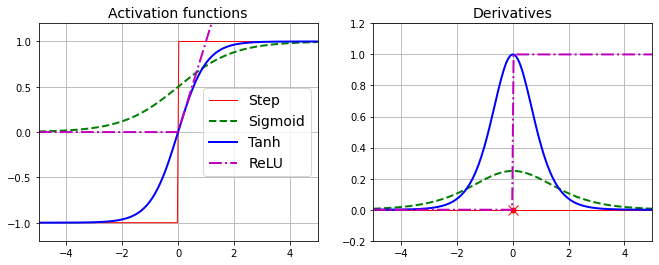

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

<h2>MLPs de Regresión y Clasificación</h2>

Las MLP se pueden utilizar para multitud de tareas, tanto de regresión como de clasificación. Vamos a ver cómo se utilizan para cada caso.

<h3>MLPs de Regressión</h3>

Imagina que quieres predecir un valor (por ejemplo un precio de un activo), en este caso solo necesitas una neurona output con el valor predicho. Para regresión multivariante (predecir varios valores) necesitarás más neuronas en la capa output, una por cada valor que se quiera predecir.

En general, cuando se hace un MLP para regresión no se quiere usar función de activación para las neuronas output, para que puedan tomar cualquier valor. Solo en los casos en los que el output tenga alguna restricción (p.e. deba ser positivo), se tomará alguna de estas funciones (en el ejemplo, la ReLU o la softplus).

La función de pérdida que se suele usar es la mean squared error. En casos especiales se usan otras, como cuando tienes muchos atípicos y usas la función de mean absolute error, o la Huber loss, que es una combinación de las dos. Si el output puede tomar un rango determinado de valores se usan la Logistic o la Tanh.

Resumiendo los distintos hiperparámetros que tendria la MLP:
    - Neuronas input: una por cada input feature.
    - Capas ocultas: depende del problema (suele ser 1-5).
    - Neuronas por cada capa oculta: depende del problema (suele ser 10-100).
    - Neuronas output: 1 por cada dimensión predicha.
    - Función de activación de las capas ocultas: ReLU (o SELU).
    - Función de activación de la capa output: ninguna o ReLU/SoftPLUS o Logistic/Tanh.
    - Loss function: MSE o MAE/Huber.

<h3>MLPs de Clasificación</h3>

Los MLP también se pueden usar para clasificación. Para problemas binarios, sólo necesitas una neurona output usando una función de activación Logistic (así dará algo cercano a 0 o 1). La probabilidad de que pertenezca a la clase es de la probabilidad obtenida (o de 1-prob para la otra clase).

Con MLP también se pueden estudiar sistemas binarios multilabel. Por ejemplo filtros de spam y si a la vez es urgente o no. En este caso se necesitan dos neuronas output funcionando como la del ejemplo anterior. En general necesitas una neurona para cada clase a predecir. 

En casos en los que las clases tengan mas de una posibilidad (por ejemplo números del 0 al 9), llamado multiclass classification, se necesita una neurona output para cada posibilidad, y utilizar la función softmax para determinar, ya que son clases exclusivas.

En cuanto a loss function se suele usar la cross-entropy.

Resumiendo los hiperparámetros:
    - Input y capas ocultas: como en regresión.
    - Número de neuronas output: 1 en binario, 1 por etiqueta en mutilabel, 1 por clase en multiclass.
    - Función de activación output: Logistic en binario y multilabel, Softmax en multiclass.
    - Loss function: Cross-Entropy.
    

<h2>Implementación de MLP con Keras. Construcción de distintos modelos. Guardado. Uso de callbacks y visualización</h2>

Keras es una API de Deep Learning a alto nivel que permite construir, entrenar, evaluar y ejecutar todo tipo de redes neuronales. La documentación está en https://keras.io/ y su implementación en https://github.com/keras-team/keras . Es muy popular porque es fácil de usar, y para la computación se sirve de TensorFlow, Microsift Cognitive Toolkit (CNTK) o Theano. 

Desde 2016 existen otras implementaciones de Keras. Ahora se puede ejecutar desde Apache MXNet, Apple's Core ML, Javascript o Typescript (para correrlo en un entorno web) o PlaidML (para ejecutarlo en cualquier GPU, no solo Nvidia). Además TensorFlow ahora trae su Keras propio, llamado tf.keras que sólo soporta TensorFlow como Backend pero tiene features útiles. Por esto vamos a usar esta implementación en este y en los siguientes Notebooks.

<h3> Construcción de un clasificador de imagen</h3>

Vamos a construir el primer modelo con Keras, usando el dataset fashion MNIST, que tiene imágenes de ropa en lugar de números pero conserva el mismo formato que el MNIST (70000 imágenes en blanco y negro de 28x28 y en 10 clases).

Este dataset viene cargado en keras por defecto:

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test,y_test) = fashion_mnist.load_data()

In [5]:
print('tamaño del dataset',X_train_full.shape)
print('tipo del dataset:',X_train_full.dtype)

tamaño del dataset (60000, 28, 28)
tipo del dataset: uint8


In [6]:
# Vamos a crear un training y un test:

X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Ponemos las clases:

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Ejemplo:
print('Ejemplo de clase: ',class_names[y_train[0]])

Ejemplo de clase:  Coat


Vamos a construir nuestra primera NN! Esta vez va a tener, por ejemplo, dos hidden layers:

In [7]:
# Esta línea crea un modelo Sequential, que es el marco más simple de NN apiladas
model = keras.models.Sequential()
# Esta línea ñade al modelo la primera capa. Computa X, hace X.reshape(-1,1). No tiene parámetros porque solo
# hace preprocessing y sirve como capa input al proceso.
model.add(keras.layers.Flatten(input_shape=[28,28])) 
# Ahora se añaden las 2 capas intermedias con función ReLU:
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
# Como capa final se añade una capa densa con 10 neuronas (una para cada clase) y función softmax:
model.add(keras.layers.Dense(10,activation='softmax'))

# En realidad todo esto se suele escribir de una forma más correcta, en lugar de añadir capas una a una se hace
# todo de una vez. Primero limpiamos para que no sobreescriba el modelo:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_random_seed(42)

# Y creamos:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# Las model layer son:

print('model layers: ',model.layers)

# Y el summary del modelo es:
print(model.summary())

# Ademas se pueden conseguir los weights y los biases de cada capa:

print('')
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
print('El tamaño de weights:', weights.shape)
print('Ejemplo de weights:', weights[:10,:])

W0306 18:08:07.230985 140224505124672 deprecation.py:506] From /home/kiko/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


model layers:  [<tensorflow.python.keras.layers.core.Flatten object at 0x7f87f9f6ca50>, <tensorflow.python.keras.layers.core.Dense object at 0x7f87f9f28fd0>, <tensorflow.python.keras.layers.core.Dense object at 0x7f87f9ee1850>, <tensorflow.python.keras.layers.core.Dense object at 0x7f87f9ee16d0>]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
________________

Como se ve, las Dense layer están ya inicializadas por defecto de forma random, para romper la simetría y que sirvan a la hora de entrenar. Si se quiere inicializar de forma distinta, se puede usar el kernel_initialiter o bias_initialiter en los hiperparámetros.

Si no se inicializa la capa input con input_shape, keras espera hasta que entrenes para definir ese tamaño.


Los ejemplos de código documentados en keras.io también funcionan con tf.keras. Para ello basta con cambiar los imports, por ejemplo de keras:

    from keras.layers import Dense
    output_layer = Dense(10)
    
De tensorflow:
    
    from tensorflow.keras.layers import Dense
    output_layer = Dense(10)
    
    from tensorflow import keras
    output_layer = keras.layers.Dense(10)
    
Los dos ejemplos de tensorflow son válidos.



Arriba hemos visto también el summary de los modelos. Esa función muestra los distintos nombres de capas y sus parámetros entrenables y no entrenables. En nuestro ejemplo todos los parámetros son entrenables, y las capas densas tienen muchísimos parámetros. Esto hace que el modelo sea muy flexible entrenando los datos, lo que puede dar lugar a overfitting, sobre todo si no tienes demasiados datos.

Existen otros atributos como .layers, .get_weights() o .shape que te muestran las capas o los pesos y su tamaño.

Una vez se crea un modelo, este se compila usando la función compile(). Esto permite definir la loss function y el optimizer a usar. También es posible especificar una lista de métricas extra a computar durante el entrenamiento y la evaluación.

In [8]:
# Se compila el modelo:

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# Otra forma equivalente es:

#model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#              optimizer=keras.optimizers.SGD(),
#              metrics=[keras.metrics.sparse_categorical_accuracy])

W0306 18:08:08.288309 140224505124672 deprecation.py:506] From /home/kiko/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:127: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Al compilar se ha utilizado "sparse_categorical_crossentropy" porque se tienen etiquetas unas pocas etiquetas y son exclusivas (solo se puede tener un target index, de 0 a 9 en este caso). Si se necesitase saber la probabilidad por clase se podria usar "categorical_crossentropy". Si fuese clasificación binaria en lugar de multietiqueta, se usaria la función sigmoid en ligar de la softmax y habría que poner "binary_crossentropy".

Después, se ha utilizado el optimizer "sgd" para entrenar el modelo usando un Stochastic Gradient Descent. Con esto keras usará el algoritmo que hemos explicado mas arriba (reverse-mode autodiff + Gradient Descent). En otros notebooks veremos otros optimizers.

Por último, como es un classifier, la métrica a usar es "accuracy".

Una vez se ha compilado el modelo está listo para ser entrenado. Para ello sólo hace falta utilizar el método .fit(). Se pasa el input, el target y el número de epochs a entrenar (por defecto es 1, que no parece buena idea). De forma opcional se puede pasar un validation set, y keras computará la pérdida y la métrica extra al final de cada epoch. Esto permite controlar el overfitting, que sabremos que está ocurriendo si el performance en el training set es mucho mejor que en el validation set.

In [9]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 53us/sample - loss: 1.5064 - acc: 0.5600 - val_loss: 1.0095 - val_acc: 0.6850
Epoch 2/30
55000/55000 [==============================] - 3s 49us/sample - loss: 0.8802 - acc: 0.7099 - val_loss: 0.7741 - val_acc: 0.7506
Epoch 3/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.7353 - acc: 0.7581 - val_loss: 0.6813 - val_acc: 0.7848
Epoch 4/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.6636 - acc: 0.7833 - val_loss: 0.6248 - val_acc: 0.8012
Epoch 5/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.6160 - acc: 0.7990 - val_loss: 0.5861 - val_acc: 0.8158
Epoch 6/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.5820 - acc: 0.8101 - val_loss: 0.5580 - val_acc: 0.8222
Epoch 7/30
55000/55000 [==============================] - 3s 47us/sample - loss: 0.5564 - acc: 0.8171 - val_loss: 0.5

Como hemos puesto un validation set, se pueden comparar los resultados en el training y en el validation. Al final de cada epoch keras muestra el número de instances procesadas y las métricas en training y val. En el ejemplo hemos tenido una accuracy de 86,72% en el validation, nada mal. Otra forma, sin pasar validation_data, se puede usar validation_split con el ratio del set a usar como validation (p.e. 0.1).

Si el training data fuese muy skewed habria clases sobrerrepresentadas sobre otras. Se podría usar el argumento class_weight cuando se haga el .fit(), para dar mayor peso a las clases infrarrepresentadas y menor peso a las sobrerrepresentadas. Estos pesos se tienen en cuenta a la hora de computar la pérdida. Si existen ciertas instances mas importantes (por ejemplo, etiquetadas por expertos), se puede usar el argumento sample_weight para darle mas pesos. Se puede dar como argumento los sample weights metiendolos como un tercer item en el validation_data tuple.

El método .fit() devuelve un histórico con los parámetros de entrenamiento, la lista de las epochs y un diccionario con las métricas. Vamos a ver un plot:

Parámetros:  {'batch_size': 32, 'epochs': 30, 'steps': None, 'samples': 55000, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}


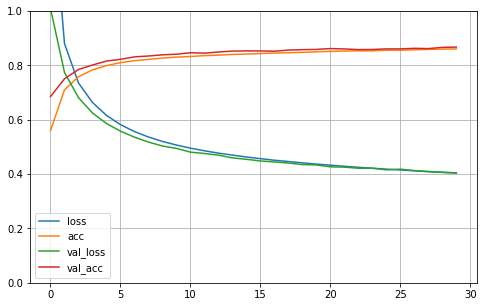

In [10]:
# Parámetros:
print('Parámetros: ',history.params)

# Plots:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Se ve en la gráfica que las curvas de train y val van bastante juntas. Eso es señal de que no hay overfitting. El hecho de que haya mejor performance sobre el val es pura casualidad. Lo normal es que, si se alarga el entrenamiento, el training set tenga una mejor performance.

Se ve que las métricas seguian mejorando. Esto nos indica que sería una buena idea seguir entrenándolo. Es posible simplemente llamando al .fit() otra vez, porque keras lo retoma donde lo dejó.

Si no estas contento con el performance debes volver atras y cambiar los hiperparámetros (p.e. el número de capas, de neuronas por capa, la función de activación, el número de epochs o el batch size). Esto lo veremos más adelante.

Una vez estes contento con el accuracy de tu validation, lo suyo es evaluarlo en el test antes de ponerlo en producción. Para ello se usa el método evaluate() (que además soporta argumentos como batch_size o sample_weight).


Nota: NUNCA se usa el test set como referencia para los hiperparámetros!!!

In [11]:
model.evaluate(X_test,y_test)

10000/10000 [==============================] - 0s 29us/sample - loss: 76.9105 - acc: 0.8106


[76.91052300434113, 0.8106]

Ya se puede usar el modelo para hacer predicciones! Para ello basta con usar el método .predict() sobre nuevas instances: 

In [12]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

En este caso nos ha dado probabilidades del 100%, pero podrían haber salido dispersas entre varias clases. Si lo que se quiere es obtener una única prediccion, la de la clase, se debe usar el método .predict_classes():

In [13]:
y_pred = model.predict_classes(X_new)
print('Las predicciones son:',y_pred)
print('Los valores reales eran:',y_test[:3])
print('Y las clases son:', np.array(class_names)[y_pred])


Las predicciones son: [9 2 1]
Los valores reales eran: [9 2 1]
Y las clases son: ['Ankle boot' 'Pullover' 'Trouser']


<h3> Construcción de un MLP de regresión con la Sequential API</h3>

Para estudiar el problema de regresión vamos a usar el dataset de California housing pricing. Para esto vamos a usar la version de SKlearn fetch_california_housing(), que solo tiene las features numéricas y no tiene missings.

In [14]:
# Importamos el dataset
housing = fetch_california_housing()
# Separamos en train, test y valid:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full)

# Escalamos los datos con el Scaler:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Crear un modelo de regresión con MLP es similar al de clasificación hecho. La diferencia principal es que la última capa está formada por una única neurona porque solo queremos predecir un valor, y no tiene ninguna función de activación y la loss function es el mean squared error. Como el dataset es un poco malo, tiene mucho ruido, vamos a usar solo una hidden layer para evitar overfitting:

In [15]:
# Establecemos semilla:
np.random.seed(42)
tf.random.set_random_seed(42)

# Creamos la estructura de la NN
model = keras.models.Sequential([
    keras.layers.Dense(30,activation="relu",input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

# Compilamos el modelo:
model.compile(loss='mean_squared_error',optimizer='sgd')

# Creamos el histórico, predecimos y vemos como funciona en unos cuantos registros:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 57us/sample - loss: 2.7227 - val_loss: 1.2091
Epoch 2/20
11610/11610 [==============================] - 1s 47us/sample - loss: 0.9287 - val_loss: 0.8145
Epoch 3/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.7439 - val_loss: 0.7193
Epoch 4/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.6839 - val_loss: 0.6838
Epoch 5/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.6470 - val_loss: 0.6433
Epoch 6/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.6197 - val_loss: 0.6198
Epoch 7/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5949 - val_loss: 0.5946
Epoch 8/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.5736 - val_loss: 0.5741
Epoch 9/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5554 - val_l

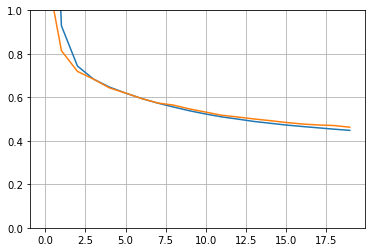

In [16]:
# lo pintamos a ver que tal:

plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

<h3>Modelos complejos usando la Functional API: Wide & Deep Neural Network</h3>

Un ejemplo de NN no secuencial es la Wide & Deep NN. Esta se divide en dos partes, una deep NN clásica y una capa que conecta directamente los inputs con la capa output. Con esto se consigue que la NN aprenda patrones complejos (a partir de la parte deep NN) y patrones simples (a partir de la conexion directa).

Vamos a construir esto para el dataset de California:

In [17]:
# Establecemos semilla:
np.random.seed(42)
tf.random.set_random_seed(42)

# Hacemos el Wide & Deep:

# Primero creamos el input object. Hacemos esto asi porque luego tendremos varios inputs:
input_ = keras.layers.Input(shape=X_train.shape[1:])

# Creamos dos capas hidden, dense y de 30 neuronas y con ReLu. Además las conectamos con la capa anterior. Esto
# es la Functional API, se pasa el input como si fuese una función.
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

# Creamos un objeto concatenate que concatene el input y el output de la segunda hidden layer.
concat = keras.layers.concatenate([input_, hidden2])

# Creamos la capa output, dense y con una única neurona y sin función de activacion.
output = keras.layers.Dense(1)(concat)

# Por último, se crea el modelo Keras con el input y el output
model = keras.models.Model(inputs=[input_], outputs=[output])

# Veamos el summary:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [18]:
# Hagamos una predicción con el modelo. Para ello compile, fit, evaluate y predict:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 61us/sample - loss: 1.9005 - val_loss: 0.7827
Epoch 2/20
11610/11610 [==============================] - 1s 47us/sample - loss: 0.6932 - val_loss: 0.7261
Epoch 3/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.6331 - val_loss: 0.6446
Epoch 4/20
11610/11610 [==============================] - 1s 48us/sample - loss: 0.6036 - val_loss: 0.6349
Epoch 5/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5788 - val_loss: 0.5889
Epoch 6/20
11610/11610 [==============================] - 1s 47us/sample - loss: 0.5605 - val_loss: 0.6011
Epoch 7/20
11610/11610 [==============================] - 1s 46us/sample - loss: 0.5432 - val_loss: 0.5687
Epoch 8/20
11610/11610 [==============================] - 1s 47us/sample - loss: 0.5296 - val_loss: 0.5528
Epoch 9/20
11610/11610 [==============================] - 1s 46us/sample - loss: 0.5191 - val_l

Puede suceder que se quiera mandar, a la vez, un subset por el deep NN y otro por el path directo. Para ello se crean múltiples inputs. Si, por ejemplo, se quieren mandar un subset de variables por cada path (en el ejemplo son variables 0-4 por el deep, variables 2-7 por el wide) sería así:

In [19]:
# Establecemos semilla:
np.random.seed(42)
tf.random.set_random_seed(42)

# Con variables distintas por cada path:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

# Predecimos:

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]


# Al hacer el fit, evaluate o predict, hay que pasar el par de matrices distintas:
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 65us/sample - loss: 2.3558 - val_loss: 1.1897
Epoch 2/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.8680 - val_loss: 0.8099
Epoch 3/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.7173 - val_loss: 0.7172
Epoch 4/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.6631 - val_loss: 0.6746
Epoch 5/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.6276 - val_loss: 0.6394
Epoch 6/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5999 - val_loss: 0.6165
Epoch 7/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5773 - val_loss: 0.5969
Epoch 8/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5586 - val_loss: 0.5804
Epoch 9/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.5438 - val_l

También puede ocurrir que se necesiten múltiples outputs, por ejemplo:

    - Si la tarea lo exige: por ejemplo si se quiere encontrar y localizar un objeto en una imagen, es a la vez una tarea de clasificación del objeto y de regresión (encontrar las coordenadas del centro del objeto.
    - Si se realizan distintas tareas independientes sobre los mismos datos. Se puede entrenar una NN para cada tarea, pero suele dar mejores resultados hacer todas las tareas sobre una misma NN con un output por tarea, porque la NN puede aprender patrones comunes entre distintas tareas.
    - Como técnica de regularización: por ejemplo, se pueden añadir outputs auxiliares para asegurar que las capas bajas de la NN aprenden patrones sin ceder todo el peso a las capas superiores. Con este tipo de técnicas se consigue que el modelo generalice mejor y se reduce el overfitting.
    
Añadir outputs extra es tan sencillo como conectarlos en las capas que se desee, y añadirlos a la lista de outputs. Por ejemplo:

In [20]:
# Establecemos semilla:
np.random.seed(42)
tf.random.set_random_seed(42)

# Modelo con regularización que añade outputs en la capa hidden2:

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

# Compilamos y entrenamos/evaluamos. Para compilar se debe añadir una loss function ara cada output:

# Además, se puede dar distinto peso a cada métrica. Por defecto Keras hace 50/50.
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

# Se deben pasar labels para cada output, así que en este caso hay que poner 2 veces el y_train:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

# La pérdida total es una conjunción de ambas, y Keras nos devuelve ambas y la total:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

# Con las predicciones tambien nos devuelve ambas:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 77us/sample - loss: 2.7219 - main_output_loss: 2.4435 - aux_output_loss: 5.2272 - val_loss: 1.3539 - val_main_output_loss: 1.0704 - val_aux_output_loss: 3.9055
Epoch 2/20
11610/11610 [==============================] - 1s 61us/sample - loss: 1.0331 - main_output_loss: 0.8314 - aux_output_loss: 2.8485 - val_loss: 0.9393 - val_main_output_loss: 0.7383 - val_aux_output_loss: 2.7479
Epoch 3/20
11610/11610 [==============================] - 1s 60us/sample - loss: 0.7978 - main_output_loss: 0.6611 - aux_output_loss: 2.0274 - val_loss: 0.8126 - val_main_output_loss: 0.6450 - val_aux_output_loss: 2.3214
Epoch 4/20
11610/11610 [==============================] - 1s 62us/sample - loss: 0.7145 - main_output_loss: 0.6038 - aux_output_loss: 1.7108 - val_loss: 0.7504 - val_main_output_loss: 0.6086 - val_aux_output_loss: 2.0264
Epoch 5/20
11610/11610 [==============================] - 1s 60us/s

Como se ha visto, entrenar cualquier tipo de arquitectura de NN es tan sencillo como añadir las capas correspondientes y conectarlas en el lugar que corresponda!

<h3>Modelos dinámicos usando la Subclassing API</h3>

Tanto la Sequential API como la Functional API son declarativas, por ello se empieza definiendo las capas que vas a usar y cómo están conectadas, y después ya puedes entrenar el modelo. Esto tiene ventajas como que los modelos pueden ser guardados, clonados, compartidos, analizados, se pueden inferir capas y check types permitiendo encontrar los errores rápido. Además es muy fácil de debuggear porque el modelo es un grafo estático de capas. Pero su principal contra es eso, que es estático. Algunos modelos necesitan recursividad (como bucles), capas condicionales, tamaños que cambian y otros comportamientos dinámicos. Para eso, o porque prefieres más libertad a la hora de programar, se utiliza la Subclassing API.

Es tan simple como hacer una subclase de la clase Model, crear las capas que se necesitan en el constructor y usarlas para realizar las computaciones que se quieran con el método call(). Por ejemplo, para el WideAndDeepModel de antes:

In [21]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs) # Esto hereda los argumentos del __init__ de Model, como por ej name
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel()

Esto es muy parecido a la Functional API, pero no necesitamos crear los inputs porque solo estamos definiendo la clase. Se meterán los inputs cuando se llame al método call(), y podemos separar la creacion de las layers en el constructor de su uso en el método call(). Esto permite hacer lo que quieras en el método call(), ya sea bucles, ifs, operaciones o lo que quieras.

La contraparte a esto es que tu arquitectura del modelo estará oculta bajo el método call(), por lo que Keras no puede inspeccionarla, guardarla, clonarla o sacar información de las layers cuando hagas el summary(). De hecho, summary() solo muestra una lista de capas, sin información de las mismas o de las conexiones entre ellas (esto es derivado de que, al no definir el input al crearlas, keras no es capaz de recorrer la estructura). Por eso, si no se necesita una flexibilidad extra, es mejor usar las API Sequential o Functional.

Nota: Es posible usar los modelos de Keras como si fuesen una única capa, por lo que se pueden componer entre si para crear arquitecturas complejas.

<h3> Guardado y restaurado de un modelo Keras</h3>

Guardar un modelo Keras es tan simple como usar la función .save() La única condición es que deben ser modelos de API Functional o Sequential, nunca Subclass:

In [22]:
# El ejemplo de antes:

# Establecemos semilla:
np.random.seed(42)
tf.random.set_random_seed(42)

# Modelo con regularización que añade outputs en la capa hidden2:

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

# Compilamos y entrenamos/evaluamos. Para compilar se debe añadir una loss function ara cada output:

# Además, se puede dar distinto peso a cada métrica. Por defecto Keras hace 50/50.
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

# Se deben pasar labels para cada output, así que en este caso hay que poner 2 veces el y_train:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

# La pérdida total es una conjunción de ambas, y Keras nos devuelve ambas y la total:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

# Con las predicciones tambien nos devuelve ambas:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

model.save('my_keras_model.h5')

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 78us/sample - loss: 1.9937 - main_output_loss: 1.7825 - aux_output_loss: 3.8944 - val_loss: 1.4750 - val_main_output_loss: 1.2898 - val_aux_output_loss: 3.1416
Epoch 2/20
11610/11610 [==============================] - 1s 61us/sample - loss: 1.0243 - main_output_loss: 0.8536 - aux_output_loss: 2.5601 - val_loss: 1.0984 - val_main_output_loss: 0.9688 - val_aux_output_loss: 2.2643
Epoch 3/20
11610/11610 [==============================] - 1s 62us/sample - loss: 0.8688 - main_output_loss: 0.7472 - aux_output_loss: 1.9631 - val_loss: 0.9229 - val_main_output_loss: 0.8223 - val_aux_output_loss: 1.8279
Epoch 4/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.7901 - main_output_loss: 0.6913 - aux_output_loss: 1.6791 - val_loss: 0.8253 - val_main_output_loss: 0.7365 - val_aux_output_loss: 1.6239
Epoch 5/20
11610/11610 [==============================] - 1s 62us/s

Keras guardará la arquitectura del modelo (incluyendo los hiperparámetros de cada capa) y los valores de todo el modelo para cada capa (los pesos de conexiones y los biases) usando el formato HDF5. Además guarda el optimizer y sus hiperarámetros (y su estado).

Lo típico es tener un script que crea el modelo y lo guarda, y uno o mas scripts (o web services) que lo cargan y lo usan para predecir. Cargar modelos es igual de simple que guardar, basta con usar la función load_model():

In [23]:
model= keras.models.load_model('my_keras_model.h5')

W0306 18:10:34.250461 140224505124672 deprecation.py:506] From /home/kiko/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Aunque no se pueda usar para la Subclassing API, se pueden usar las funciones save_weights() y load_weights() para al menos guardar y restaurar los parámetros del modelo (pero todo lo demas lo tienes que guardar y restaurar por tu cuenta).

En el caso (bastante común) de que el entrenamiento dure horas, no solo es necesario guardar el modelo al final del entrenamiento, si no que es conveniente guardar checkpoints a distintos intervalos del entrenamiento. Para decirle al método fit() que guarde checkpoints se usan los callbacks.

<h3> Uso de Callbacks</h3>

El método fit() permite un argumento callbacks, que permite poner una lista de objetos que Keras hará durante el entrenamiento (al principio y al final del entrenamiento, al principio y al final de cada epoch o incluso despues de procesar cada batch). Por ejemplo, el callback ModelCheckpoing guarda checkpoints de tu modelo a intervalos regulares durante el entrenamiento (por defecto al principio y al final de cada epoch).

Además permite funcionalidades como el argumento save_best_only=True, que guardará el modelo solo cuando el desempeño en el validation set es mejor que el ya guardado. Esto es una forma muy simple de immplementar early stopping y evitar el overfitting: 

In [24]:
# Limpiamos de modelos y establecemos semilla
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_random_seed(42)

# Creamos un modelo genérico para enseñar el callback:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

# Ejemplo de Checkpoint cada epoch y que guarde el mejor modelo:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

# Rollback al mejor modelo
model = keras.models.load_model("my_keras_model.h5")
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 60us/sample - loss: 1.5410 - val_loss: 0.7476
Epoch 2/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.6487 - val_loss: 0.6214
Epoch 3/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5806 - val_loss: 0.5781
Epoch 4/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5412 - val_loss: 0.5516
Epoch 5/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5129 - val_loss: 0.5236
Epoch 6/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4908 - val_loss: 0.5131
Epoch 7/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4737 - val_loss: 0.4945
Epoch 8/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4595 - val_loss: 0.4818
Epoch 9/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4480 - val_l

Otra forma de hacer el early stopping es con el callback EarlyStopping. Esto detiene el entrenamiento cuando ya no se mejore en el validation set por un número de epochs definido en el argumento patience, y opcionalmente hace rollback al mejor modelo. Se pueden combinar ambos rollback para hacer checkpoints (por si tu ordenador crashea) e interrumpir el entrenamiento cuando ya no haya mejoras:

In [25]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.4292 - val_loss: 0.4592
Epoch 2/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4217 - val_loss: 0.4479
Epoch 3/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4150 - val_loss: 0.4445
Epoch 4/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4091 - val_loss: 0.4395
Epoch 5/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4036 - val_loss: 0.4352
Epoch 6/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.3990 - val_loss: 0.4300
Epoch 7/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3948 - val_loss: 0.4274
Epoch 8/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.3909 - val_loss: 0.4243
Epoch 9/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.387

Epoch 76/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3260 - val_loss: 0.3646
Epoch 77/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.3258 - val_loss: 0.3606
Epoch 78/100
11610/11610 [==============================] - 1s 48us/sample - loss: 0.3252 - val_loss: 0.3637
Epoch 79/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.3249 - val_loss: 0.3647
Epoch 80/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3244 - val_loss: 0.3605
Epoch 81/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3242 - val_loss: 0.3622
Epoch 82/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3235 - val_loss: 0.3634
Epoch 83/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3232 - val_loss: 0.3591
Epoch 84/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.3228 - val_loss: 0.3599
Epoch 85/100
11610/

Existen otros muchos callbacks en keras.callbacks() (https://keras.io/api/callbacks/).

Si se necesita un control extra, se pueden definir callbacks propios. Un ejemplo:

In [26]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10752/11610 [==========================>...] - ETA: 0s - loss: 0.3158
val/train: 1.12
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3159 - val_loss: 0.3539


Se pueden implementar callbacks en los siguientes puntos: on_train_begin(), on_train_end(), on_epoch_begin(), on_epoch_end(), on_batch_begin(), on_batch_end(). Además se pueden usar para evaluación y predicción, por lo que se pueden implementar también en on_test_begin(), ..., on_test_batch_end() si se llaman desde evaluate(), o en on_predict_begin(), ..., on_predict_batch_end() si se llama desde predict().

<h3>Visualización usando TensorBoard</h3>

TensorBoard es una herramienta de TensorFlow (se instala automáticamente con este) que permite analizar curvas y compararlas durante el entrenamiento.

Para usarlo, basta con modificar el programa para que saque como output el data que quieras visualizar usando unos archivos de log binarios llamados "event files". Cada binary data guardado es llamado "summary". El servidor de TensorBoard monitorizará el directorio log y permitirá visualizar en directo parámetros como las learning curve durante el entrenamiento. En general te interesa apuntar con el servidor TensorBoard a un root log directory, y configurar tu programa para que escriba en distintos subdirectorios cada vez que ejecutes. De esta forma el servidor de TensorBoard te permitirá comparar entre distintas ejecuciones de tu programa sin mezclarlo todo.

El código estará comentado porque es un notebook de estudio.

In [27]:
# Se carga el server de TensorBoard en Jupyter asi:

#%load_ext tensorboard
#%tensorboard --logdir=./my_logs --port=6006

# Creacion del directorio:

# root_logdir = os.path.join(os.curdir, "my_logs")

#def get_run_logdir():
#    import time
#    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#    return os.path.join(root_logdir, run_id)

#run_logdir = get_run_logdir()
#run_logdir

# Ejemplo de modelo:

#keras.backend.clear_session()
#np.random.seed(42)
#tf.random.set_random_seed(42)

#model = keras.models.Sequential([
#    keras.layers.Dense(30, activation="relu", input_shape=[8]),
#    keras.layers.Dense(30, activation="relu"),
#    keras.layers.Dense(1)
#])    
#model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

# Uso del callback TensorBoard de Keras:

#tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
#history = model.fit(X_train, y_train, epochs=30,
#                    validation_data=(X_valid, y_valid),
#                    callbacks=[checkpoint_cb, tensorboard_cb])

<h2>Fine-Tuning de hiperparámetros. Número de capas ocultas, de neuronas por capa, learning rate y otros.</h2>

<h3>Fine-Tuning de hiperparámetros</h3>

La flexibilidad de las NN es también su principal problema, porque tiene muchos hiperparámetros para tunear. Por ejemplo, el número de capas, el número de neuronas por capas, el tipo de función de activación, la lógica de iniciación de los pesos y más. En esta sección aprenderemos cómo combinar de forma eficiente los hiperparámetros.

La primera opción es hacer una GridSearchCV o RandomizedSearchCV de distintos parámetros y quedarse con aquello que mejor funcione para el validation test. Para esto hay que convertir los modelos Keras en elementos que Sklearn sepa gestionar:

In [28]:
# Limpiamos de modelos y establecemos semilla
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_random_seed(42)

# Primero definimos la función genérica que crea el modelo que vamos a generar. Este modelo será secuencial y 
# para una regresión univariante (una neurona output):
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu',**options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model
# El diccionario options se usa para asegurar que la primera capa es correctamente informada en el input shape, 
# así si n_hidden=0, la primera capa será la capa output.

# Una vez se ha creado el modelo genérico, se crea un KerasRegressor, que ya permite ser usado como un objeto de 
# Sklearn:

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# Como no hemos especificado parámetros al crear el keras_reg, va a usar los genéricos que pusimos en la definición
# de build_model. Ya podemos usar este elemento como un regressor de Sklearn: entrenarlo con fit(), evaluar con 
# score() y predecir con predict().

# NOTA: cualquier hiperparámetro que se pase por fit() se pasará al modelo Keras inferior, y el score que se 
# obtendrá será el opuesto del MSE, porque Sklearn busca scores, no losses (más alto es mejor):

keras_reg.fit(X_train, y_train, epochs=100,
    validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)




Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 55us/sample - loss: 1.1624 - val_loss: 1.4561
Epoch 2/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.7169 - val_loss: 1.8601
Epoch 3/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.5865 - val_loss: 0.6223
Epoch 4/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.5065 - val_loss: 0.5728
Epoch 5/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4722 - val_loss: 0.4848
Epoch 6/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4568 - val_loss: 0.5041
Epoch 7/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4406 - val_loss: 0.4606
Epoch 8/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4302 - val_loss: 0.4561
Epoch 9/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.422

Epoch 76/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.3331 - val_loss: 0.3641
Epoch 77/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.3328 - val_loss: 0.3703
Epoch 78/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.3330 - val_loss: 0.3634
Epoch 79/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.3320 - val_loss: 0.3668
Epoch 80/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.3315 - val_loss: 0.3686
Epoch 81/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.3313 - val_loss: 0.3618
Epoch 82/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.3312 - val_loss: 0.3685
Epoch 83/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.3307 - val_loss: 0.3634
Epoch 84/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.3300 - val_loss: 0.3615
Epoch 85/100
11610/

Sin embargo, no queremos entrenar un único modelo como arriba, si no que queremos entrenar cientos de versiones y ver cual tiene mejor performance. Como existen multitud de hiperparámetros, es aconsejable usar RandomizedSearchCV que GridSearchCV:

In [30]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(), 
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=78, n_hidden=2, learning_rate=0.0005086711330891658 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 1s 70us/sample - loss: 3.2103 - val_loss: 2.0331
Epoch 2/100
7740/7740 [==============================] - 0s 52us/sample - loss: 1.2700 - val_loss: 1.1257
Epoch 3/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.8671 - val_loss: 0.8385
Epoch 4/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.7441 - val_loss: 0.7457
Epoch 5/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.6947 - val_loss: 0.7025
Epoch 6/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.6664 - val_loss: 0.6779
Epoch 7/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.6461 - val_loss: 0.6591
Epoch 8/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.6290 - val_loss: 0.6438
Epoch 9/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.6135 - val_loss: 0.6309
Epoch 10/100
7740/7740 [==============================] - 

Epoch 78/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3648 - val_loss: 0.3998
Epoch 79/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3639 - val_loss: 0.3989
Epoch 80/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3631 - val_loss: 0.3993
Epoch 81/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3622 - val_loss: 0.3974
Epoch 82/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3614 - val_loss: 0.3968
Epoch 83/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3606 - val_loss: 0.3968
Epoch 84/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3598 - val_loss: 0.3954
Epoch 85/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3590 - val_loss: 0.3947
Epoch 86/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3583 - val_loss: 0.3938
Epoch 87/100
7740/7740 [=============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.7s remaining:    0.0s


7740/7740 [==============================] - 1s 72us/sample - loss: 3.3178 - val_loss: 2.7328
Epoch 2/100
7740/7740 [==============================] - 0s 55us/sample - loss: 1.4822 - val_loss: 1.3906
Epoch 3/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.9168 - val_loss: 0.8955
Epoch 4/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7370 - val_loss: 0.7397
Epoch 5/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.6728 - val_loss: 0.6830
Epoch 6/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.6427 - val_loss: 0.6552
Epoch 7/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.6235 - val_loss: 0.6386
Epoch 8/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.6088 - val_loss: 0.6265
Epoch 9/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5959 - val_loss: 0.6156
Epoch 10/100
7740/7740 [==============================] - 

Epoch 78/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3689 - val_loss: 0.4106
Epoch 79/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3681 - val_loss: 0.4114
Epoch 80/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3673 - val_loss: 0.4104
Epoch 81/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3666 - val_loss: 0.4092
Epoch 82/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3659 - val_loss: 0.4090
Epoch 83/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3652 - val_loss: 0.4085
Epoch 84/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3645 - val_loss: 0.4085
Epoch 85/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3638 - val_loss: 0.4069
Epoch 86/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3632 - val_loss: 0.4070
Epoch 87/100
7740/7740 [=============

7740/7740 [==============================] - 0s 51us/sample - loss: 0.4002 - val_loss: 0.4270
Epoch 52/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3984 - val_loss: 0.4254
Epoch 53/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3967 - val_loss: 0.4241
Epoch 54/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3951 - val_loss: 0.4229
Epoch 55/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3936 - val_loss: 0.4217
Epoch 56/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3920 - val_loss: 0.4206
Epoch 57/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3904 - val_loss: 0.4196
Epoch 58/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3890 - val_loss: 0.4188
Epoch 59/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3875 - val_loss: 0.4179
Epoch 60/100
7740/7740 [==========================

Epoch 11/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.3751 - val_loss: 0.3993
Epoch 12/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.3839 - val_loss: 0.4089
Epoch 13/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3773 - val_loss: 0.4053
Epoch 14/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3551 - val_loss: 0.3894
Epoch 15/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3551 - val_loss: 0.3854
Epoch 16/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3510 - val_loss: 0.3823
Epoch 17/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3921 - val_loss: 0.4007
Epoch 18/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.4824 - val_loss: 0.4232
Epoch 19/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3668 - val_loss: 0.4055
Epoch 20/100
7740/7740 [=============

7740/7740 [==============================] - 0s 52us/sample - loss: 0.3782 - val_loss: 0.4179
Epoch 10/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3737 - val_loss: 0.4092
Epoch 11/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.3697 - val_loss: 0.4040
Epoch 12/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3673 - val_loss: 0.4107
Epoch 13/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3657 - val_loss: 0.3979
Epoch 14/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3622 - val_loss: 0.3958
Epoch 15/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.3601 - val_loss: 0.3904
Epoch 16/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3567 - val_loss: 0.3974
Epoch 17/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3547 - val_loss: 0.3918
Epoch 18/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 57us/sample - loss: 0.3250 - val_loss: 0.3699
Epoch 43/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3238 - val_loss: 0.3710
Epoch 44/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3234 - val_loss: 0.3736
Epoch 45/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3223 - val_loss: 0.3727
Epoch 46/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3217 - val_loss: 0.3756
Epoch 47/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3210 - val_loss: 0.3680
Epoch 48/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3201 - val_loss: 0.3695
Epoch 49/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3194 - val_loss: 0.3661
Epoch 50/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3184 - val_loss: 0.3664
Epoch 51/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 56us/sample - loss: 0.3982 - val_loss: 0.4260
Epoch 16/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3916 - val_loss: 0.4225
Epoch 17/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3858 - val_loss: 0.4222
Epoch 18/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.3815 - val_loss: 0.4156
Epoch 19/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3767 - val_loss: 0.4164
Epoch 20/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3735 - val_loss: 0.4078
Epoch 21/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3697 - val_loss: 0.4075
Epoch 22/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3664 - val_loss: 0.4038
Epoch 23/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3636 - val_loss: 0.4050
Epoch 24/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 57us/sample - loss: 0.2943 - val_loss: 0.3371
Epoch 92/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2940 - val_loss: 0.3390
Epoch 93/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.2933 - val_loss: 0.3378
Epoch 94/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.2928 - val_loss: 0.3419
Epoch 95/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2924 - val_loss: 0.3365
Epoch 96/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.2917 - val_loss: 0.3453
Epoch 97/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.2920 - val_loss: 0.3335
Epoch 98/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.2915 - val_loss: 0.3426
Epoch 99/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2908 - val_loss: 0.3366
Epoch 100/100
7740/7740 [=========================

7740/7740 [==============================] - 0s 57us/sample - loss: 0.3108 - val_loss: 0.3553
Epoch 65/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3097 - val_loss: 0.3547
Epoch 66/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3095 - val_loss: 0.3508
Epoch 67/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3084 - val_loss: 0.3526
Epoch 68/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3080 - val_loss: 0.3451
Epoch 69/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3075 - val_loss: 0.3488
Epoch 70/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3066 - val_loss: 0.3471
Epoch 71/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3055 - val_loss: 0.3555
Epoch 72/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3054 - val_loss: 0.3471
Epoch 73/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 50us/sample - loss: 0.3587 - val_loss: 0.3979
Epoch 43/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3584 - val_loss: 0.3975
Epoch 44/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3583 - val_loss: 0.3980
Epoch 45/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3574 - val_loss: 0.3970
Epoch 46/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3572 - val_loss: 0.3955
Epoch 47/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3546 - val_loss: 0.4002
Epoch 48/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3552 - val_loss: 0.3947
Epoch 49/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3531 - val_loss: 0.3961
Epoch 50/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3546 - val_loss: 0.3974
Epoch 51/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 50us/sample - loss: 0.4003 - val_loss: 0.4371
Epoch 16/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3971 - val_loss: 0.4344
Epoch 17/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3942 - val_loss: 0.4312
Epoch 18/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3923 - val_loss: 0.4344
Epoch 19/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3896 - val_loss: 0.4273
Epoch 20/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3878 - val_loss: 0.4293
Epoch 21/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3851 - val_loss: 0.4222
Epoch 22/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3840 - val_loss: 0.4280
Epoch 23/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3827 - val_loss: 0.4215
Epoch 24/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 50us/sample - loss: 0.3318 - val_loss: 0.3870
Epoch 92/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3319 - val_loss: 0.3821
Epoch 93/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3425 - val_loss: 0.3725
Epoch 94/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3408 - val_loss: 0.3767
Epoch 95/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.3212
[CV]  n_neurons=16, n_hidden=1, learning_rate=0.005968408643972776, total=  37.1s
[CV] n_neurons=16, n_hidden=1, learning_rate=0.005968408643972776 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 90us/sample - loss: 1.2735 - val_loss: 0.6006
Epoch 2/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5280 - val_loss: 0.7416
Epoch 3/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.50

7740/7740 [==============================] - 0s 54us/sample - loss: 0.3270 - val_loss: 0.3797
Epoch 41/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3261 - val_loss: 0.3804
Epoch 42/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3253 - val_loss: 0.3804
Epoch 43/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3248 - val_loss: 0.3775
Epoch 44/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3238 - val_loss: 0.3768
Epoch 45/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3228 - val_loss: 0.3765
Epoch 46/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3218 - val_loss: 0.3740
Epoch 47/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3213 - val_loss: 0.3733
Epoch 48/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3206 - val_loss: 0.3744
Epoch 49/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 54us/sample - loss: 0.3879 - val_loss: 0.4246
Epoch 14/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3823 - val_loss: 0.4233
Epoch 15/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3779 - val_loss: 0.4159
Epoch 16/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3739 - val_loss: 0.4203
Epoch 17/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3709 - val_loss: 0.4136
Epoch 18/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3680 - val_loss: 0.4113
Epoch 19/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3658 - val_loss: 0.4075
Epoch 20/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3633 - val_loss: 0.4052
Epoch 21/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3609 - val_loss: 0.4000
Epoch 22/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 55us/sample - loss: 0.4918 - val_loss: 0.5412
Epoch 6/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4788 - val_loss: 0.5229
Epoch 7/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.4670 - val_loss: 0.5301
Epoch 8/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.4589 - val_loss: 0.4949
Epoch 9/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.4510 - val_loss: 0.5048
Epoch 10/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.4435 - val_loss: 0.5039
Epoch 11/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.4367 - val_loss: 0.4985
Epoch 12/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.4318 - val_loss: 0.4694
Epoch 13/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.4261 - val_loss: 0.4571
Epoch 14/100
7740/7740 [==============================

7740/7740 [==============================] - 0s 54us/sample - loss: 0.3246 - val_loss: 0.3569
Epoch 82/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3235 - val_loss: 0.3585
Epoch 83/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.3233 - val_loss: 0.3606
Epoch 84/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.3233 - val_loss: 0.3607
Epoch 85/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.3225 - val_loss: 0.3570
Epoch 86/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3224 - val_loss: 0.3552
Epoch 87/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3221 - val_loss: 0.3555
Epoch 88/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3217 - val_loss: 0.3553
Epoch 89/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3214 - val_loss: 0.3548
Epoch 90/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 53us/sample - loss: 0.2737 - val_loss: 0.3300
Epoch 55/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.2746 - val_loss: 0.3243
Epoch 56/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.2726 - val_loss: 0.3309
Epoch 57/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.2724 - val_loss: 0.3217
Epoch 58/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.2713 - val_loss: 0.3273
Epoch 59/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.2728 - val_loss: 0.3244
Epoch 60/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.2711 - val_loss: 0.3184
Epoch 61/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.2687 - val_loss: 0.3264
Epoch 62/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.2697 - val_loss: 0.3214
Epoch 63/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 61us/sample - loss: 0.3049 - val_loss: 0.3541
Epoch 28/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3061 - val_loss: 0.3582
Epoch 29/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3008 - val_loss: 0.3817
Epoch 30/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3019 - val_loss: 0.3401
Epoch 31/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3047 - val_loss: 0.3537
Epoch 32/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.2962 - val_loss: 0.3371
Epoch 33/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2991 - val_loss: 0.3627
Epoch 34/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2941 - val_loss: 0.3373
Epoch 35/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2977 - val_loss: 0.3636
Epoch 36/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 62us/sample - loss: 1.3059 - val_loss: 1.3286
Epoch 5/100
7740/7740 [==============================] - 0s 58us/sample - loss: 1.2889 - val_loss: 1.3268
Epoch 6/100
7740/7740 [==============================] - 0s 54us/sample - loss: 1.2858 - val_loss: 1.3207
Epoch 7/100
7740/7740 [==============================] - 0s 57us/sample - loss: 1.2764 - val_loss: 1.3106
Epoch 8/100
7740/7740 [==============================] - 0s 58us/sample - loss: 1.2703 - val_loss: 1.3105
Epoch 9/100
7740/7740 [==============================] - 0s 55us/sample - loss: 1.2669 - val_loss: 1.2774
Epoch 10/100
7740/7740 [==============================] - 0s 54us/sample - loss: 1.2407 - val_loss: 1.2134
Epoch 11/100
7740/7740 [==============================] - 0s 58us/sample - loss: 1.1974 - val_loss: 1.2992
Epoch 12/100
7740/7740 [==============================] - 0s 56us/sample - loss: 1.1656 - val_loss: 1.0985
Epoch 13/100
7740/7740 [==============================]

7740/7740 [==============================] - 0s 55us/sample - loss: 0.4847 - val_loss: 0.4494
Epoch 3/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.4053 - val_loss: 0.4330
Epoch 4/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3839 - val_loss: 0.4139
Epoch 5/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3712 - val_loss: 0.4299
Epoch 6/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3651 - val_loss: 0.4082
Epoch 7/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3547 - val_loss: 0.4002
Epoch 8/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3478 - val_loss: 0.3924
Epoch 9/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3400 - val_loss: 0.3837
Epoch 10/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3355 - val_loss: 0.3797
Epoch 11/100
7740/7740 [==============================] -

7740/7740 [==============================] - 0s 54us/sample - loss: 0.2585 - val_loss: 0.3269
Epoch 79/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.2583 - val_loss: 0.3271
Epoch 80/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2593 - val_loss: 0.3177
Epoch 81/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.2600 - val_loss: 0.3245
Epoch 82/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.2594 - val_loss: 0.3251
Epoch 83/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.2569 - val_loss: 0.3084
Epoch 84/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2581 - val_loss: 0.3180
Epoch 85/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.2555 - val_loss: 0.3087
Epoch 86/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.2573 - val_loss: 0.3269
Epoch 87/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 54us/sample - loss: 0.2714 - val_loss: 0.3905
Epoch 59/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.2715 - val_loss: 0.4707
Epoch 60/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.2708 - val_loss: 0.4026
Epoch 61/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2703 - val_loss: 0.4511
Epoch 62/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.2601
[CV]  n_neurons=35, n_hidden=2, learning_rate=0.015375618870770533, total=  27.6s
[CV] n_neurons=59, n_hidden=0, learning_rate=0.0003166202999165769 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 116us/sample - loss: 6.6312 - val_loss: 10.7057
Epoch 2/100
7740/7740 [==============================] - 0s 47us/sample - loss: 4.8667 - val_loss: 7.7155
Epoch 3/100
7740/7740 [==============================] - 0s 49us/sample - loss: 3.

7740/7740 [==============================] - 0s 49us/sample - loss: 0.5826 - val_loss: 0.6149
Epoch 70/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5809 - val_loss: 0.6131
Epoch 71/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5792 - val_loss: 0.6113
Epoch 72/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5776 - val_loss: 0.6096
Epoch 73/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5760 - val_loss: 0.6079
Epoch 74/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5745 - val_loss: 0.6063
Epoch 75/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5728 - val_loss: 0.6047
Epoch 76/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5714 - val_loss: 0.6031
Epoch 77/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5700 - val_loss: 0.6016
Epoch 78/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 47us/sample - loss: 0.6013 - val_loss: 0.6233
Epoch 43/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5995 - val_loss: 0.6212
Epoch 44/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5977 - val_loss: 0.6191
Epoch 45/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.5960 - val_loss: 0.6172
Epoch 46/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5942 - val_loss: 0.6155
Epoch 47/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5926 - val_loss: 0.6135
Epoch 48/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5910 - val_loss: 0.6116
Epoch 49/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5894 - val_loss: 0.6099
Epoch 50/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5878 - val_loss: 0.6083
Epoch 51/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 51us/sample - loss: 0.7122 - val_loss: 1.1740
Epoch 16/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6875 - val_loss: 1.0870
Epoch 17/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6679 - val_loss: 1.0115
Epoch 18/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6523 - val_loss: 0.9460
Epoch 19/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.6396 - val_loss: 0.8893
Epoch 20/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6293 - val_loss: 0.8402
Epoch 21/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6207 - val_loss: 0.7979
Epoch 22/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.6134 - val_loss: 0.7610
Epoch 23/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6072 - val_loss: 0.7293
Epoch 24/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 48us/sample - loss: 0.5467 - val_loss: 0.5768
Epoch 43/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5454 - val_loss: 0.5753
Epoch 44/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5441 - val_loss: 0.5744
Epoch 45/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5430 - val_loss: 0.5730
Epoch 46/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5418 - val_loss: 0.5717
Epoch 47/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5407 - val_loss: 0.5708
Epoch 48/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5397 - val_loss: 0.5692
Epoch 49/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5386 - val_loss: 0.5683
Epoch 50/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5376 - val_loss: 0.5673
Epoch 51/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 48us/sample - loss: 0.6791 - val_loss: 0.6986
Epoch 16/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.6702 - val_loss: 0.6904
Epoch 17/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.6627 - val_loss: 0.6836
Epoch 18/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6565 - val_loss: 0.6777
Epoch 19/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.6510 - val_loss: 0.6723
Epoch 20/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6460 - val_loss: 0.6672
Epoch 21/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6414 - val_loss: 0.6628
Epoch 22/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6373 - val_loss: 0.6585
Epoch 23/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.6332 - val_loss: 0.6547
Epoch 24/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 48us/sample - loss: 0.5347 - val_loss: 0.5461
Epoch 92/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5344 - val_loss: 0.5456
Epoch 93/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5339 - val_loss: 0.5451
Epoch 94/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5337 - val_loss: 0.5446
Epoch 95/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5332 - val_loss: 0.5441
Epoch 96/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5329 - val_loss: 0.5437
Epoch 97/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5326 - val_loss: 0.5432
Epoch 98/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5322 - val_loss: 0.5428
Epoch 99/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5320 - val_loss: 0.5423
Epoch 100/100
7740/7740 [=========================

7740/7740 [==============================] - 1s 66us/sample - loss: 0.2957 - val_loss: 0.3511
Epoch 31/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.2941 - val_loss: 0.3449
Epoch 32/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.2922 - val_loss: 0.3484
Epoch 33/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.2915 - val_loss: 0.3431
Epoch 34/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2891 - val_loss: 0.3458
Epoch 35/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.2878 - val_loss: 0.3455
Epoch 36/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.2862 - val_loss: 0.3371
Epoch 37/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.2848 - val_loss: 0.3405
Epoch 38/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.2842 - val_loss: 0.3437
Epoch 39/100
7740/7740 [==========================

7740/7740 [==============================] - 1s 66us/sample - loss: 0.3172 - val_loss: 0.3573
Epoch 17/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.3133 - val_loss: 0.3701
Epoch 18/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.3109 - val_loss: 0.3557
Epoch 19/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.3077 - val_loss: 0.3601
Epoch 20/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3061 - val_loss: 0.3553
Epoch 21/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3049 - val_loss: 0.3479
Epoch 22/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3017 - val_loss: 0.3463
Epoch 23/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.2993 - val_loss: 0.3505
Epoch 24/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.2982 - val_loss: 0.3565
Epoch 25/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 58us/sample - loss: 0.2870 - val_loss: 0.3519
Epoch 41/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2875 - val_loss: 0.3337
Epoch 42/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.2847 - val_loss: 0.3497
Epoch 43/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.2835 - val_loss: 0.3578
Epoch 44/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2826 - val_loss: 0.3392
Epoch 45/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2812 - val_loss: 0.3363
Epoch 46/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2807 - val_loss: 0.3483
Epoch 47/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.2793 - val_loss: 0.3295
Epoch 48/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2789 - val_loss: 0.3418
Epoch 49/100
7740/7740 [==========================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.6min finished


11610/11610 [==============================] - 1s 120us/sample - loss: 0.8786 - val_loss: 0.6314
Epoch 2/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4798 - val_loss: 0.5229
Epoch 3/100
11610/11610 [==============================] - 1s 61us/sample - loss: 0.4100 - val_loss: 0.4248
Epoch 4/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.3806 - val_loss: 0.4156
Epoch 5/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.3683 - val_loss: 0.3948
Epoch 6/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.3564 - val_loss: 0.3958
Epoch 7/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.3545 - val_loss: 0.4230
Epoch 8/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.3452 - val_loss: 0.3876
Epoch 9/100
11610/11610 [==============================] - 1s 57us/sample - loss: 0.3423 - val_loss: 0.4232
Epoch 10/100
11610/11610 [=============

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f87fbedf510>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_hidden': [0, 1, 2, 3], 'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, ...6591264410276, 0.00561403910405859, 0.015148912343132669, 0.004025069608970383, 0.0101290138640658]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

Es idéntico a cualquier RandomizedSearchCV de Sklearn, con la excepción de que le pasamos parámetros extra que caen directamente al modelo Keras. Además, RandomizedSearchCV utiliza un K-Fold CV, por lo que no usa X_valid ni y_valid, estos solo se usan para el callback de early stopping. 

Esta ejecución puede durar horas en función del hardware, es un entrenamiento MUY pesado. Una vez acabe, se pueden explorar los parámetros típicos de cualquier ejecución de Sklearn con un RandomizedSearchCV, por ejemplo:

    - rnd_search_cv.best_params_
    - rnd_search_cv.best_score_
    - rnd_search_cv.best_estimator_
    - rnd_search_cv.score(X_test, y_test)
    - etc.
    
Y se puede entrenar el mejor modelo para usarlo con el siguiente código:

    model = rnd_search_cv.best_estimator_.model
    model
    
Que evalua con:

    model.evaluate(X_test, y_test)
    
Además, este modelo puede ser guardado, cargado y esas cosas.

Existen formas más eficientes de buscar en el espacio de variables por la combinación correcta. La idea siempre es la misma, buscar una región del espacio que parezca buena y después explorar dentro de esta. Este es un grupo de librerias Python que sirven para optimizar hiperparámetros:

    - Hyperopt: librería popular de Python para optimizar sobre todos cualquier tipo de espacio de variables complejo, como learning rates o valores discretos como el número de layers.
    - Hyperas, kopt o Talos: Optimización de hiperparámetros de Keras (los dos primeros se basan en Hyperopt).
    - Scikit-Optimize (skopt): una librería de optimización de uso general. Tiene un método BayesSearchCV que realiza un CV de optimización Bayesiana con una interfaz similar a GridSearchCV.
    - Spearmint: librería de optimización Bayesiana.
    - Sklearn-Deap: una librería de optimización de hiperparámetros basada en algoritmos evolutivos. Tiene una interfaz similar a GridSearchCV.
    - ...
    
Existen otras compañias que ofrecen servicios de optimización de hiperparámetros. Por ejemplo, Google Cloud ML Engine tiene este servicio. Otras empresas proveen de APIs de optimización como Arimo, SigOpt o Oscar.

El tuneo de hiperparámetros es un área activa de investigación, y los algoritmos evolutivos están revolucionando el área. Por ejemplo, DeepMint sacó un paper en 2017 donde optimizaban conjuntamente un grupo de modelos y sus hiperparámetros. Google además usó un algoritmo evolutivo no sólo para encontrar los mejores hiperparámetros, si no también la mejor estructura de NN para el problema. Lo llamaron AutoML, y está disponible como un servicio cloud. (Post sobre esto https://ai.googleblog.com/2018/03/using-evolutionary-automl-to-discover.html)

Esto abre la puerta al pensamiento de que la época en la que se construyan las arquitecturas de NN de forma manual están llegando a su fin. De hecho los algoritmos evolutivos se están usando de forma eficiente para entrenar NN individuales reemplazando a los Gradient Descent. (Post sobre esto https://eng.uber.com/deep-neuroevolution/).

A pesar de todo esto, siempre ayuda tener una idea general de cómo selecionar valores razonables para los hiperparámetros. Eso vamos a ver ahora.

<h3>Número de capas ocultas</h3>

Para casi todos los problemas se puede empezar con una única capa. Teóricamente un MLP con una capa puede realizar cualquier función compleja si tiene las suficientes neuronas. El motivo por el que se usan deep networks es que son mucho más eficientes en cuanto a parámetros: pueden realizar las mismas tareas complejas con un valor exponencialmente menor de neuronas, lo que hace que tenga un rendimiento muchisimo mejor con el mismo número de datos.

La explicación a esto es que los datos suelen estar estructurados de una forma jerárquica, y las redes neuronales profundas se aprovechan de ello. Las capas mas bajas modelan estructuras de bajo nivel (p.e. lineas y segmentos de varias direcciones y formas), las capas intermedias modelan estructuras de nivel medio (por ejemplo cuadrados, circulos...) y las capas altas modelan estructuras complejas (por ejemplo caras). Esto permite converger de una forma más eficiente a soluciones mejores e incluso generalizar mejor para datasets nuevos. Por ejemplo, si tienes un modelo para reconocer caras en fotos, y quieres entrenar uno que reconozca cortes de pelo, puedes reutilizar las capas bajas y reentrenar las altas. Esto se llama Transfer Learning, y acelera enormemente el entrenamiento.

Para la mayoría de problemas puedes empezar con una o dos capas ocultas (p.e. el MNIST se modela a un 97% con una capa oculta, y mas del 98% con 2, de forma muy sencilla además). Para problemas complejos, se puede ir aumentando el número de capas ocultas hasta llegar al overfitting. Problemas complejos, como image classification o spech recognition, suelen requerir decenas o centenares de capas (pero normalmente no suelen ser fully-connected, esto ya lo veremos en un notebook posterior). Sin embargo nunca se suelen entrenar de 0, lo normal es reutilizar partes de redes entrenadas en el state-of-the-art que hagan una tarea similar. Esto agiliza muchisimo el entrenamiento y reduce drásticamente la cantidad de datos utilizados.

<h3>Número de neuronas por capa</h3>

Obviamente, las neuronas de las capas input y output vienen determinadas por el tipo de input y output de tu problema (p.e. MNIST son 28x28 input y 10 output).

Era típico estructurar las capas ocultas en forma de pirámide. Sin embargo, se ha abandonado esta idea al parecer que usar el mismo número de neuronas para cada capa funciona igual (y a veces mejor), y sólo se debe modelar un hiperparámetro en lugar de uno cada capa. Depende de cada problema, y algunas veces si que compensa hacer la primera capa mayor.

Igual que para el número de capas, se puede aumentar el número de neuronas hasta que se llegue al overfitting. Suele ser mas rentable aumentar el número de capas, y saber el número correcto de neuronas es todavía una caja negra.

Existen técnicas, como coger un modelo con más neuronas de las que necesitas y usar early stopping para prevenir overfitting (u otras técnicas que ya veremos, como el dropout). Esto se conoce como la técnica de "strech pants": en vez de gastar tiempo en buscar los pantalones de tu talla perfecta, coge unos grandes y adáptalos.

<h3>Learning Rate y otros</h3>

Existen otros hiperparámetros en las MLP además de los números de capas y de neuronas. Algunos son los siguientes:

    - Learning rate: es uno de los hiperparámetros más importantes. El learning rate idóneo suele ser aproximadamente la mitad del learning rate máximo (es decir, el que hace que el modelo diverja). Por esto, una forma buena de encontrar el learning rate correcto es empezar por uno muy alto que haga que el algoritmo diverja, luego dividirlo entre 3 y volver a probar, y así hasta que deje de diverger. En este punto no estarás muy lejos del óptimo. Además, a veces es útil reducir el learning rate durante el entrenamiento (ya lo veremos).
    - Elegir un optimizer mejor que el típico Mini-Batch GD y optimizar sus hiperparámetros. Ya lo veremos.
        - El batch size a veces tiene mucho impacto en los modelos. En general nunca se deben usar mini-batches mayores que 32, Un small batch pequeño asegura que cada iteración es grande, y aunque en teoría un batch size mayor da una estimación mejor de los gradientes, en la práctica no importa ya que el landscape de optimización es muy complejo y la dirección de los gradientes reales no suelen apuntar a la dirección óptima. Sin embargo, un batch size mayor que 10 suele aprovechar la optimización de hardware y software (sobre todo para multiplicación de matrices) acelerando el entrenamiento.
        - Elegir una función de activación correcta, como ya se discutió anteriormente. En general la ReLu funciona bien para las capas ocultas, y para la output depende del problema.
        - En la mayoria de los casos, en lugar de definir el número de iteraciones, es mejor usar early stopping.
        
En los siguientes notebooks veremos técnicas para entrenar redes profundas, veremos cómo personalizar los modelos usando la API de TensorFlow y como preprocesar datos con la Data API. Además veremos distintas arquitecturas de Redes Neuronales, como Redes Neuronales Convolucionales para imágenes, Redes Neuronales Recurrentes para datos secuenciales, Autoencoders para representation learning y GANs (Generative Adversarial Networks) para modelizar y generar datos. 